In [3]:
import calendar
import datetime as dt
import logging
import os
from pathlib import Path

import jax
import numpyro
import pandas as pd
import torch
import xarray as xr
from jax import numpy as jnp
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import (aes, element_blank, element_text, facet_grid, facet_wrap,
                      geom_boxplot, geom_hline, geom_line, geom_point,
                      geom_ribbon, geom_smooth, geom_vline, ggplot,
                      scale_color_brewer, scale_x_continuous, scale_x_datetime,
                      theme, theme_bw, xlab, ylab)
from sklearn.gaussian_process import kernels
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from src.data_loading.data_loading import load_data
from src.modeling.ensemble import (BoostedRegressor, DefaultEnsemble,
                                   RandomForest)
from src.modeling.gaussian_process import (HierarchicalARGP, MultitaskGP,
                                           SklearnGPModel)
from src.modeling.lm import LinearModel
from src.modeling.metrics import summarize
from src.modeling.var_models import NARX, VAR
from src.preprocessing.preprocessing import (SeasonalFeatures,
                                             XArrayFeatureUnion,
                                             XArrayStandardScaler)
from src.utils import flatten_array

logging.basicConfig(level=logging.INFO)

# device = "cuda"
device = "cpu"
torch.set_default_device(device)

device = os.environ.get("JAX_PLATFORM_NAME", "cuda")

numpyro.set_platform(device)
numpyro.set_host_device_count(4 if device == "cpu" else 1)

pd.options.display.float_format = "{:,.3f}".format

/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def rename_lakes(x):
    return {
        "eri": "Erie",
        "sup": "Superior",
        "mic_hur": "Michigan/Huron",
        "ont": "Ontario",
    }.get(x, x)


lake_data = (
    load_data(["rnbs", "precip", "temp", "evap"])
    .sel(type=["Basin", "Land", "Water"])
    .dropna("Date")
    .to_array()
    .transpose("Date", "lake", ...)
)
lake_data

<xarray.DataArray (Date: 384, lake: 4, variable: 4, type: 3)> Size: 147kB
array([[[[-20.92372 , -20.92372 , -20.92372 ],
         [ 13.33    ,  10.85    ,  16.74    ],
         [258.3     , 255.1     , 262.3     ],
         [ 57.94    ,  21.45    , 104.97    ]],

        [[ 40.5714  ,  40.5714  ,  40.5714  ],
         [ 23.25    ,  22.785   ,  24.955   ],
         [263.25    , 262.      , 265.95    ],
         [ 44.87    ,  25.485   ,  81.855   ]],

        [[ 93.83467 ,  93.83467 ,  93.83467 ],
         [ 24.8     ,  24.49    ,  26.66    ],
         [266.2     , 265.7     , 267.6     ],
         [ 29.08    ,  23.9     ,  44.02    ]],

        [[239.5306  , 239.5306  , 239.5306  ],
         [ 42.78    ,  41.54    ,  43.4     ],
         [266.3     , 265.6     , 267.7     ],
         [ 40.95    ,  30.94    ,  60.7     ]]],

...

       [[[-53.29011 , -53.29011 , -53.29011 ],
         [ 13.64    ,  14.26    ,  13.02    ],
         [266.5     , 264.5     , 269.      ],
         [ 59.74    ,  33.45    ,  93.62    ]],

        [[ -2.97982 ,  -2.97982 ,  -2.97982 ],
         [ 17.67    ,  17.36    ,  18.91    ],
         [269.      , 267.95    , 270.95    ],
         [ 57.455   ,  35.6     ,  97.235   ]],

        [[  0.      ,   0.      ,   0.      ],
         [ 16.12    ,  16.12    ,  17.36    ],
         [269.9     , 269.4     , 271.2     ],
         [ 42.62    ,  32.05    ,  72.91    ]],

        [[173.6947  , 173.6947  , 173.6947  ],
         [ 28.83    ,  27.9     ,  28.52    ],
         [269.4     , 268.6     , 270.8     ],
         [ 53.72    ,  37.04    ,  81.53    ]]]])
Coordinates:
  * Date      (Date) datetime64[ns] 3kB 1979-01-01 1979-02-01 ... 2010-12-01
  * lake      (lake) object 32B 'sup' 'mic_hur' 'eri' 'ont'
  * type      (type) object 24B 'Basin' 'Land' 'Water'
  * variable  (variable) object 32B 'rnbs' 'precip' 'temp' 'evap'
Attributes:
    source:   GLCC

In [5]:
num_splits = 5
forecast_steps = 13

test_data = lake_data.sel(Date=slice("2006", "2010"))
train_data = lake_data.sel(Date=slice(None, "2005"))

splitter = TimeSeriesSplit(n_splits=num_splits, test_size=forecast_steps, gap=0)
splits = list(splitter.split(train_data))

X, y = train_data.sel(variable=["precip", "temp", "evap"]), train_data.sel(
    variable="rnbs", type="Water"  # all types are repeats
).squeeze().drop_vars(["type", "variable"])
test_x, test_y = test_data.sel(variable=["precip", "temp", "evap"]), test_data.sel(
    variable="rnbs", type="Water"
).squeeze().drop_vars(["type", "variable"])

y_scaler = XArrayStandardScaler()
y = y_scaler.fit_transform(y)
test_y = y_scaler.transform(test_y)
for train, test in splits:
    # print(X.indexes["Date"][train], X.indexes["Date"][test])
    print(len(train), X.indexes["Date"][test])

259 DatetimeIndex(['2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01',
               '2000-12-01', '2001-01-01', '2001-02-01', '2001-03-01',
               '2001-04-01', '2001-05-01', '2001-06-01', '2001-07-01',
               '2001-08-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
272 DatetimeIndex(['2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01',
               '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01',
               '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01',
               '2002-09-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
285 DatetimeIndex(['2002-10-01', '2002-11-01', '2002-12-01', '2003-01-01',
               '2003-02-01', '2003-03-01', '2003-04-01', '2003-05-01',
               '2003-06-01', '2003-07-01', '2003-08-01', '2003-09-01',
               '2003-10-01'],
              dtype='datetime64[ns]', name='Date', freq=None)
298 DatetimeIndex(['2003-11-01', '2003-12-01', '2004-01-01', '2004-02-01'

In [6]:
plot_data = (
    lake_data.sel(variable="rnbs")
    .drop_vars(["variable", "type"])
    .to_dataframe(name="rnbs")
    .reset_index()
)

g1 = (
    ggplot(data=plot_data, mapping=aes(x="Date", y="rnbs"))
    + geom_line()
    + facet_wrap("~lake", labeller=rename_lakes)
    + theme_bw()
    + theme(axis_title_x=element_blank(), figure_size=(8, 4))
    + scale_x_datetime(labels=date_format(fmt="%Y"))
    + ylab("RNBS $\\left(mm\\right)$")
    + geom_vline(xintercept=dt.datetime(2006, 1, 1), linetype="--", color="red")
)

g1.save("./_scratch/images/raw_rnbs.png")

/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 8 x 4 in image.
/home/mcanearm/miniconda3/envs/nbs-mvp/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./_scratch/images/raw_rnbs.png


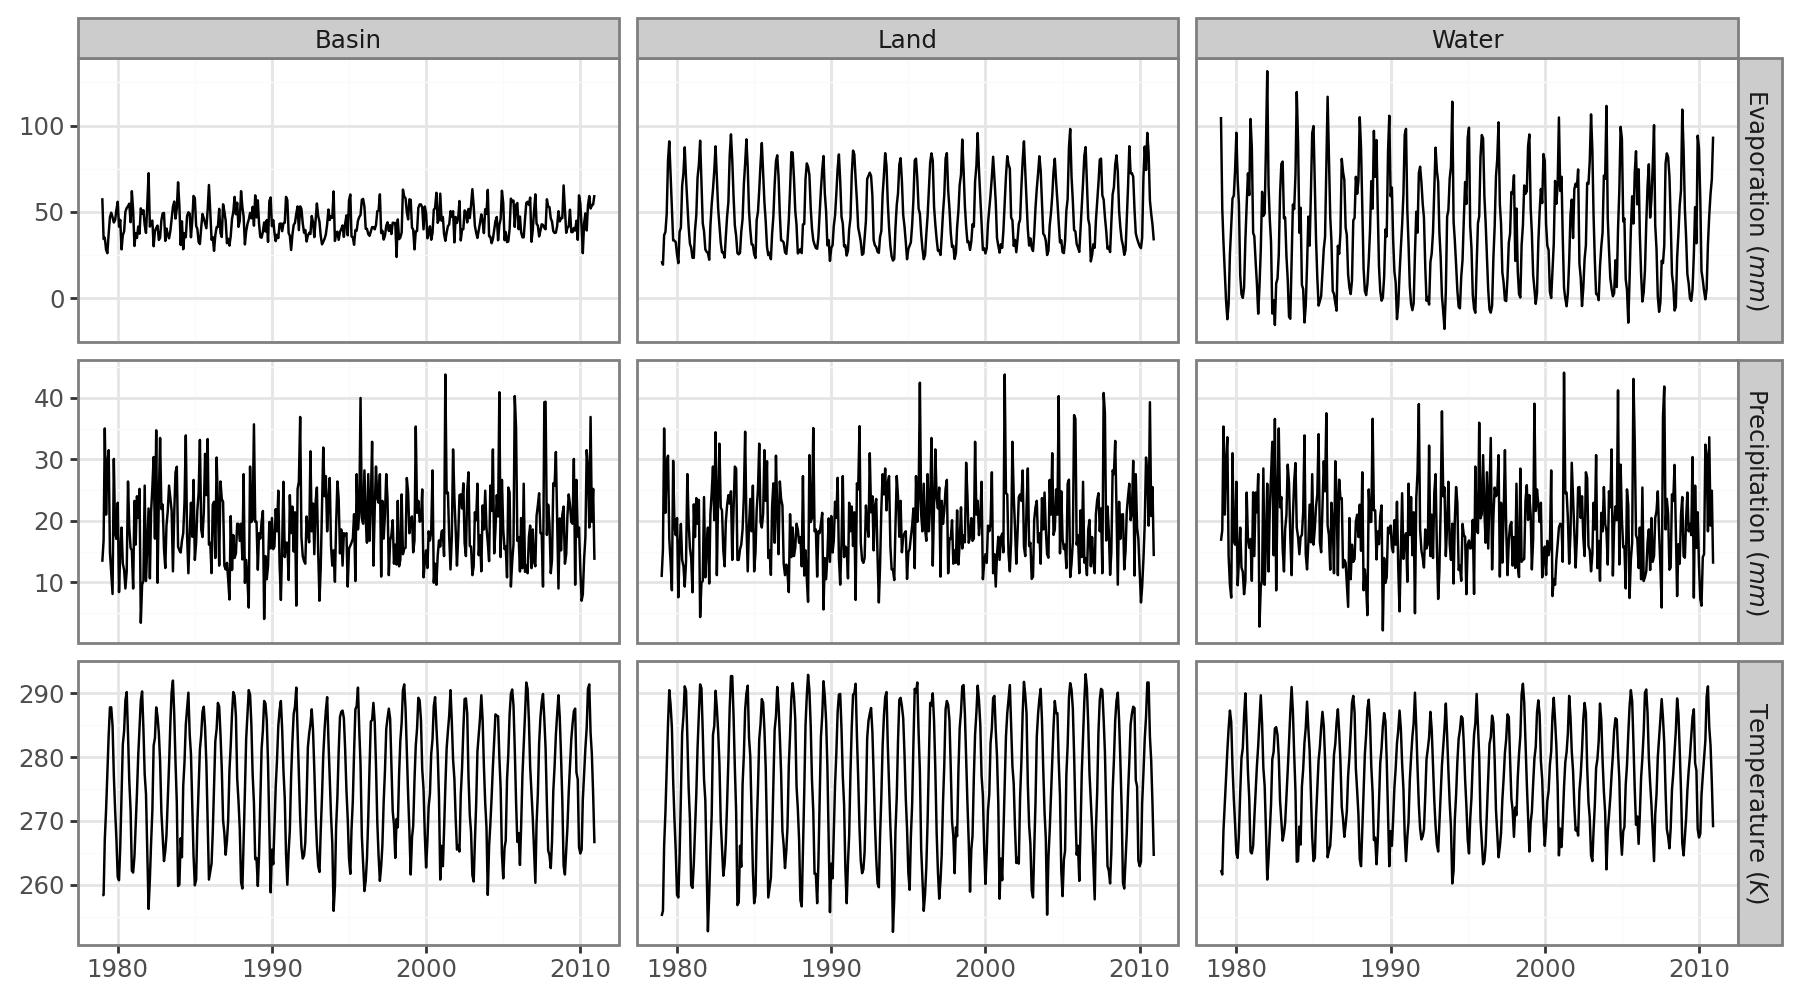

In [7]:
covar_data = (
    load_data(["precip", "temp", "evap"])
    .to_array()
    .sel(type=["Basin", "Land", "Water"], lake="sup")
    .
    # drop_vars("lake").
    dropna("Date")
    .transpose("Date", ...)
)

plot_data = covar_data.to_dataframe(
    dim_order=["Date", "type", "variable"], name="covar"
).reset_index()

(
    ggplot(data=plot_data, mapping=aes(x="Date", y="covar"))
    + geom_line()
    + facet_grid(
        "variable~type",
        scales="free_y",
        labeller=lambda x: {
            "evap": "Evaporation ($mm$)",
            "precip": "Precipitation ($mm$)",
            "temp": "Temperature ($K$)",
        }.get(x, x),
    )
    + theme_bw()
    + theme(axis_title=element_blank(), figure_size=(9, 5))
    + scale_x_datetime(labels=date_format(fmt="%Y"))
)

In [ ]:
preprocessor = XArrayFeatureUnion(
    [
        (
            "preprocess",
            Pipeline(
                steps=[
                    ("scale", XArrayStandardScaler()),
                    ("flatten", FunctionTransformer(flatten_array)),
                ]
            ),
        ),
        ("seasonal", SeasonalFeatures()),
    ]
)

gp_models = {
    "GP_Matern": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "model",
                SklearnGPModel(
                    1.0 * kernels.Matern(nu=1.5) * kernels.RationalQuadratic()
                ),
            ),
        ]
    ),
    "MultitaskGP": Pipeline(
        steps=[("preprocess", preprocessor), ("model", MultitaskGP(epochs=100, rank=1))]
    ),
    "HierarchicalARGP": Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            # ("array", FunctionTransformer(jnp.array)),
            ("model", HierarchicalARGP(num_warmup=250, num_samples=250, num_chains=4)),
        ]
    )
}

simple_models = {
    # Make sure to understand the loss function
    "SimpleLM": Pipeline(
        steps=[("preprocess", preprocessor), ("model", LinearModel())]
    ),
    "RF": Pipeline(steps=[("preprocess", preprocessor), ("model", RandomForest())]),
    "BoostedTrees": Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", BoostedRegressor(n_estimators=500, learning_rate=0.1)),
        ]
    ),
}

varx_models = {
    # why no LSTM? Because we don't have much data
    "NARX": Pipeline(
        steps=[
            ("preprocess", XArrayStandardScaler()),
            (
                "model",
                NARX(
                    lags={"y": 3, "temp": 0, "precip": 0, "evap": 0},
                    num_warmup=1000,
                    num_chains=4,
                    num_samples=1000,
                ),
            ),
        ]
    ),
    "VARX": Pipeline(
        steps=[
            ("preprocess", XArrayStandardScaler()),
            (
                "model",
                VAR(
                    lags={"y": 3, "precip": 0, "temp": 0, "evap": 0},
                    num_warmup=1000,
                    num_chains=4,
                    num_samples=1000,
                ),
            ),
        ]
    ),
}

# use only temp and precip
all_models = {
    "Default": Pipeline(
        steps=[("preprocessor", preprocessor), ("model", DefaultEnsemble())]
    ),
    **simple_models,
    **gp_models,
    **varx_models,
}


In [9]:
# run cross validation
results = []
overwrite = False
results_dir = Path("./_scratch/results")
results_dir.mkdir(exist_ok=True)
for name, model in all_models.items():
    logging.info(f"Fitting {name} model...")
    for i, (train_id, test_id) in enumerate(splits):
        prediction_file = results_dir / f"{name}_{i}.csv"
        if prediction_file.exists() and not overwrite:
            logging.info(f"Loading {name} model (split {i + 1}/{num_splits})")
            predictions = pd.read_csv(prediction_file).assign(split=i + 1)
            predictions["Date"] = pd.to_datetime(predictions["Date"])
        else:
            logging.info(f"Fitting {name} model (split {i + 1}/{num_splits})")
            model.fit(X[train_id], y[train_id])
            preds = model.predict(
                X[: max(test_id) + 1],
                forecast_steps=forecast_steps,
                sample_subset=250,
                device=jax.devices("cuda")[0]
            )

            array = xr.concat(
                [preds, y[test_id].expand_dims({"value": ["true"]}, axis=-1)],
                dim="value",
            )

            predictions = pd.concat(
                [
                    arr.to_pandas().assign(
                        months_ahead=list(range(1, forecast_steps + 1)), model=name
                    )
                    for arr in array.transpose("lake", ...)
                ],
                axis=0,
                keys=preds.lake.values,
                names=["lake"],
            ).assign(split=i + 1)
            predictions.to_csv(prediction_file)
        results.append(predictions)

cv_results = pd.concat(results, axis=0)
cv_results.head()

INFO:root:Fitting Default model...
INFO:root:Fitting Default model (split 1/5)
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:root:Fitting Default model (split 2/5)
INFO:root:Fitting Default model (split 3/5)
INFO:root:Fitting Default model (split 4/5)
INFO:root:Fitting Default model (split 5/5)
INFO:root:Fitting SimpleLM model...
INFO:root:Fitting SimpleLM model (split 1/5)
INFO:root:Fitting SimpleLM model (split 2/5)
INFO:root:Fitting SimpleLM model (split 3/5)
INFO:root:Fitting SimpleLM model (split 4/5)
INFO:root:Fitting SimpleLM model (split 5/5)
INFO:root:Fitting RF model...
INFO:root:Fitting RF model (split 1/5)
INFO:root:Fitting RF model (split 2/5)
INFO:root:Fitting RF model (split 3/5)
INFO:root

KeyboardInterrupt: 

In [8]:
cv_results_12 = cv_results[cv_results["months_ahead"] <= 12].reset_index()
cv_results_12.groupby(["lake", "model"]).apply(summarize, include_groups=False)

rmse   mae   mape  variance   bias  coverage  \
lake    model                                                        
eri     BoostedTrees 0.482 0.391 71.663     0.230  0.043     0.917   
        Default      0.632 0.517  1.926     0.393  0.076     0.933   
        GP_Matern    0.447 0.358  3.289     0.198  0.047     0.917   
        MultitaskGP  0.461 0.373  1.495     0.211  0.039     0.917   
        NARX         0.458 0.366  1.901     0.204  0.077     0.900   
        RF           0.503 0.409  3.633     0.253  0.026     0.867   
        SimpleLM     0.506 0.378  3.229     0.249  0.085     0.883   
        VARX         0.504 0.376  1.979     0.243  0.105     0.867   
mic_hur BoostedTrees 0.410 0.351  0.866     0.166  0.045     0.800   
        Default      0.678 0.535  1.476     0.443  0.128     0.917   
        GP_Matern    0.339 0.287  1.493     0.111  0.058     0.983   
        MultitaskGP  0.362 0.301  0.927     0.128  0.054     1.000   
        NARX         0.340 0.260  1.294     0.112  0.058     0.933   
        RF           0.512 0.420  5.681     0.251  0.105     0.900   
        SimpleLM     0.358 0.282  2.024     0.126  0.046     0.967   
        VARX         0.347 0.263  3.160     0.119  0.034     0.933   
ont     BoostedTrees 0.451 0.363  1.485     0.203  0.017     0.867   
        Default      0.580 0.487 12.297     0.336 -0.027     0.950   
        GP_Matern    0.442 0.345  1.724     0.190  0.075     0.933   
        MultitaskGP  0.398 0.315  0.932     0.157  0.033     0.950   
        NARX         0.454 0.335  1.823     0.196  0.102     0.917   
        RF           0.450 0.337  1.876     0.201 -0.040     0.967   
        SimpleLM     0.530 0.419  1.476     0.274  0.083     0.900   
        VARX         0.467 0.347  3.067     0.195  0.153     0.850   
sup     BoostedTrees 0.423 0.313  0.669     0.177  0.044     0.867   
        Default      0.632 0.460  1.259     0.397  0.052     0.900   
        GP_Matern    0.410 0.308  0.810     0.161  0.087     0.967   
        MultitaskGP  0.437 0.322  1.290     0.187  0.067     0.967   
        NARX         0.397 0.298  0.966     0.156  0.036     0.933   
        RF           0.531 0.364  1.660     0.279  0.053     0.850   
        SimpleLM     0.426 0.311  0.887     0.174  0.087     0.950   
        VARX         0.354 0.269  0.821     0.123  0.046     0.917   

                      interval_len  crps      N    r2  
lake    model                                          
eri     BoostedTrees         2.129 0.278 60.000 0.691  
        Default              2.256 0.360 60.000 0.260  
        GP_Matern            1.579 0.252 60.000 0.746  
        MultitaskGP          1.717 0.260 60.000 0.721  
        NARX                 1.501 0.257 60.000 0.750  
        RF                   1.939 0.286 60.000 0.621  
        SimpleLM             1.738 0.280 60.000 0.700  
        VARX                 1.553 0.277 60.000 0.710  
mic_hur BoostedTrees         1.743 0.237 60.000 0.793  
        Default              2.177 0.381 60.000 0.197  
        GP_Matern            1.579 0.194 60.000 0.878  
        MultitaskGP          1.494 0.203 60.000 0.847  
        NARX                 1.213 0.189 60.000 0.883  
        RF                   1.843 0.296 60.000 0.626  
        SimpleLM             1.421 0.201 60.000 0.868  
        VARX                 1.235 0.191 60.000 0.886  
ont     BoostedTrees         1.988 0.258 60.000 0.762  
        Default              2.177 0.334 60.000 0.434  
        GP_Matern            1.579 0.240 60.000 0.790  
        MultitaskGP          1.711 0.220 60.000 0.817  
        NARX                 1.420 0.245 60.000 0.778  
        RF                   1.865 0.256 60.000 0.727  
        SimpleLM             1.800 0.300 60.000 0.686  
        VARX                 1.408 0.257 60.000 0.750  
sup     BoostedTrees         2.112 0.230 60.000 0.768  
        Default              1.970 0.329 60.000 0.401  
        GP_Matern            1.579 0.219 60.000 0.814  
        Multitask

In [9]:
cv_results_12.groupby(["model"]).apply(summarize, include_groups=False)

,rmse,mae,mape,variance,bias,coverage,interval_len,crps,N,r2
model,,,,,,,,,,
BoostedTrees,0.442,0.355,18.671,0.194,0.037,0.863,1.993,0.251,240.000,0.755
Default,0.631,0.500,4.239,0.395,0.057,0.925,2.145,0.351,240.000,0.328
GP_Matern,0.412,0.325,1.829,0.165,0.067,0.950,1.579,0.227,240.000,0.810
MultitaskGP,0.416,0.328,1.161,0.171,0.048,0.958,1.612,0.228,240.000,0.794
NARX,0.415,0.315,1.496,0.168,0.068,0.921,1.363,0.226,240.000,0.814
RF,0.500,0.383,3.212,0.249,0.036,0.896,1.870,0.279,240.000,0.642
SimpleLM,0.460,0.347,1.904,0.206,0.075,0.925,1.620,0.252,240.000,0.765
VARX,0.424,0.314,2.257,0.172,0.085,0.892,1.362,0.229,240.000,0.811


In [ ]:
cv_results_12[cv_results_12["months_ahead"].isin([1, 3, 6, 12])].groupby(
    ["months_ahead", "model"]
).apply(summarize, include_groups=False)

rmse   mae  mape  variance  bias  coverage  \
months_ahead model                                                      
1            BoostedTrees 0.456 0.372 0.707     0.184 0.156     0.750   
             Default      0.674 0.549 4.713     0.455 0.015     0.900   
             GP_Matern    0.464 0.392 0.798     0.192 0.152     0.900   
             MultitaskGP  0.468 0.392 0.779     0.196 0.150     0.900   
             NARX         0.443 0.346 0.752     0.190 0.077     0.850   
             RF           0.543 0.466 1.514     0.270 0.158     0.900   
             SimpleLM     0.552 0.428 0.889     0.299 0.076     0.800   
             VARX         0.499 0.411 0.644     0.241 0.089     0.800   
3            BoostedTrees 0.381 0.311 4.281     0.135 0.099     0.750   
             Default      0.468 0.419 8.226     0.205 0.118     1.000   
             GP_Matern    0.321 0.277 2.819     0.096 0.087     1.000   
             MultitaskGP  0.294 0.244 0.954     0.085 0.034     1.000   
             NARX         0.421 0.331 1.422     0.157 0.144     0.900   
             RF           0.388 0.337 1.281     0.117 0.185     0.900   
             SimpleLM     0.366 0.299 6.783     0.129 0.069     1.000   
             VARX         0.367 0.288 1.447     0.132 0.051     0.950   
6            BoostedTrees 0.313 0.243 0.763     0.098 0.018     1.000   
             Default      0.463 0.360 2.481     0.161 0.232     1.000   
             GP_Matern    0.257 0.195 1.048     0.055 0.103     1.000   
             MultitaskGP  0.237 0.179 1.715     0.050 0.076     1.000   
             NARX         0.269 0.216 2.931     0.064 0.094     1.000   
             RF           0.395 0.318 0.899     0.144 0.111     0.950   
             SimpleLM     0.385 0.326 1.554     0.121 0.165     1.000   
             VARX         0.284 0.218 4.199     0.063 0.135     1.000   
12           BoostedTrees 0.428 0.373 0.849     0.071 0.335     0.850   
             Default      0.542 0.453 1.639     0.261 0.183     0.950   
             GP_Matern    0.385 0.342 2.416     0.055 0.306     1.000   
             MultitaskGP  0.389 0.346 2.679     0.060 0.303     1.000   
             NARX         0.393 0.348 1.521     0.085 0.264     1.000   
             RF           0.487 0.397 0.941     0.222 0.122     1.000   
             SimpleLM     0.424 0.320 3.516     0.081 0.314     0.950   
             VARX         0.466 0.369 1.867     0.118 0.314     0.800   

                           interval_len  crps      N     r2  
months_ahead model                                           
1            BoostedTrees         2.130 0.265 20.000  0.703  
             Default              2.145 0.387 20.000 -1.775  
             GP_Matern            1.606 0.268 20.000  0.675  
             MultitaskGP          1.673 0.268 20.000  0.667  
             NARX                 1.296 0.247 20.000  0.729  
             RF                   1.960 0.326 20.000  0.332  
             SimpleLM             1.621 0.317 20.000  0.497  
             VARX                 1.326 0.287 20.000  0.645  
3            BoostedTrees         1.815 0.223 20.000  0.648  
             Default              2.180 0.279 20.000 -0.124  
             GP_Matern            1.512 0.185 20.000  0.784  
             MultitaskGP          1.502 0.170 20.000  0.813  
             NARX                 1.319 0.238 20.000  0.735  
             RF                   1.838 0.236 20.000  0.589  
             SimpleLM             1.620 0.209 20.000  0.748  
             VARX                 1.347 0.206 20.000  0.759  
6            BoostedTrees         2.018 0.193 20.000  0.819  
             Default              2.214 0.266 20.000  0.634  
             GP_Matern            1.515 0.152 20.000  0.877  
             MultitaskGP          1.508 0.141 20.000  0.903  
             NARX                 1.315 0.158 20.000  0.859  
             RF                   1.991 0.240 20.000  0.710  
             SimpleLM             1.619 0.222 20.000  0.

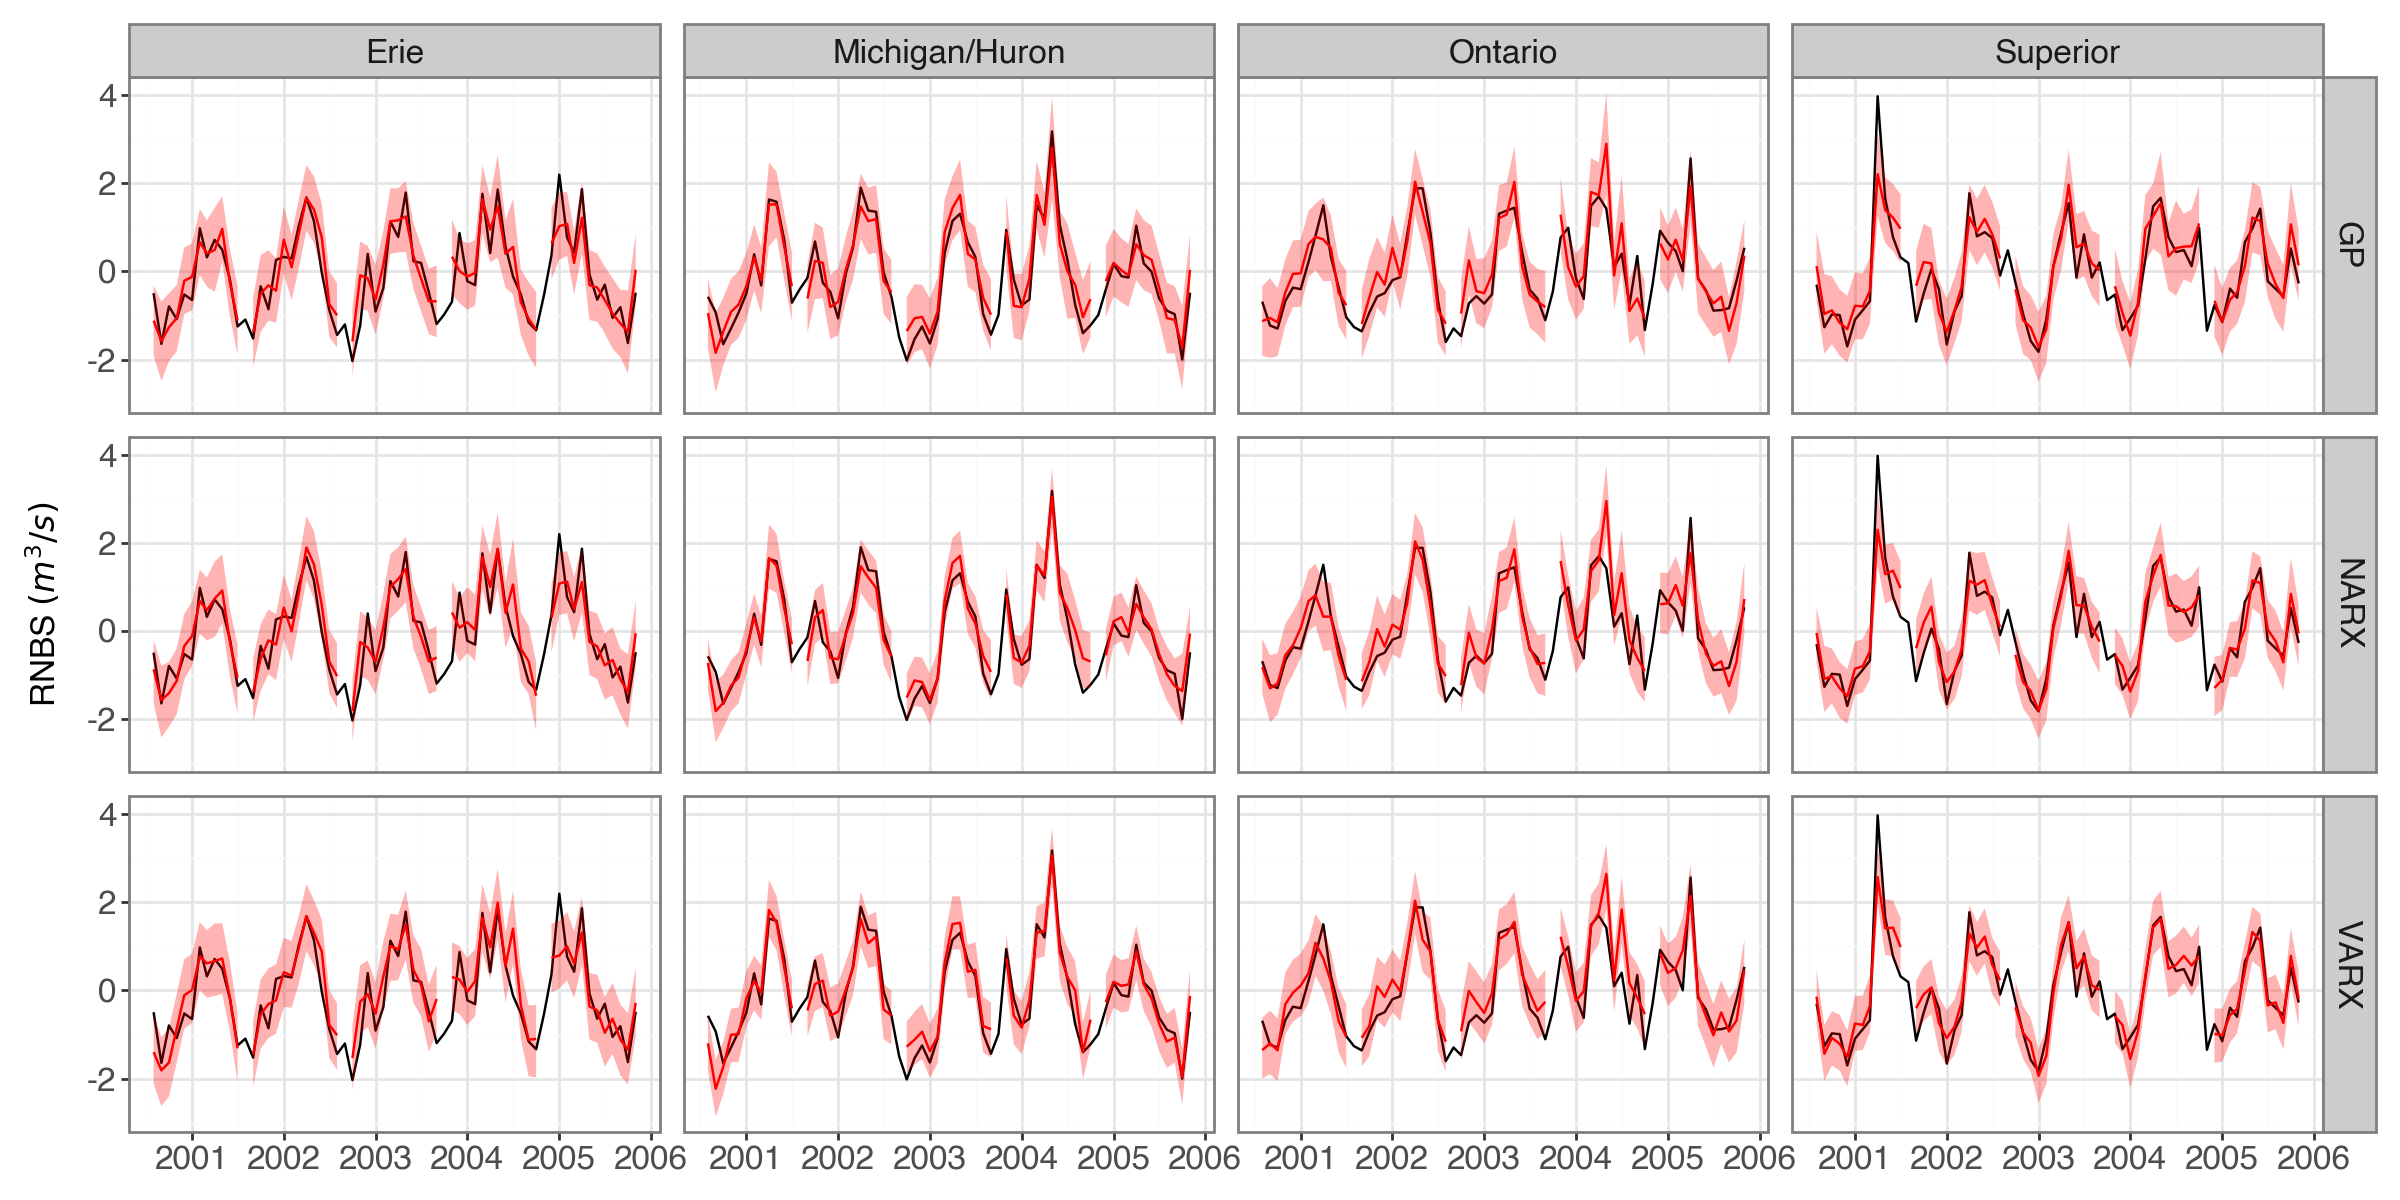

In [ ]:
import warnings

warnings.filterwarnings("ignore")

plot_data = cv_results_12[cv_results_12["split"] <= 6].reset_index()
plot_data = plot_data[plot_data["model"].isin(["GP_Matern", "VARX", "NARX"])]


def facet_rename(x):
    labels = {
        "eri": "Erie",
        "sup": "Superior",
        "mic_hur": "Michigan/Huron",
        "ont": "Ontario",
        "GP_Matern": "GP",
    }
    return labels.get(x, x)


(
    ggplot(data=plot_data, mapping=aes(x="Date", y="mean", group="split"))
    + geom_line(
        data=y.to_dataframe(name="rnbs").reset_index(),
        mapping=aes(x="Date", y="rnbs"),
        color="black",
        inherit_aes=False,
    )
    + geom_line(color="red")
    + facet_grid("model~lake", labeller=facet_rename)
    + scale_x_datetime(
        limits=[plot_data.Date.min(), plot_data.Date.max()],
        labels=date_format(fmt="%Y"),
        breaks=date_breaks("1 year"),
    )
    + geom_ribbon(
        mapping=aes(x="Date", ymin="lower", ymax="upper"), alpha=0.3, fill="red"
    )
    + ylab("RNBS $\\left(m^3/s\\right)$")
    + theme_bw()
    + theme(
        text=element_text(size=12), figure_size=(12, 6), axis_title_x=element_blank()
    )
)

In [ ]:
cv_results_12.groupby(
    [cv_results_12["Date"].dt.month, cv_results_12["Date"].dt.month_name()]
).apply(summarize)

,,rmse,mae,mape,variance,bias,coverage,interval_len,crps,N,r2
Date,Date,,,,,,,,,,
1,January,0.500,0.380,2.978,0.234,0.128,0.856,1.595,0.272,160.000,0.457
2,February,0.352,0.281,5.352,0.104,0.140,0.981,1.650,0.199,160.000,0.653
3,March,0.334,0.255,25.632,0.104,0.083,0.988,1.702,0.188,160.000,0.730
4,April,0.626,0.431,0.539,0.327,-0.254,0.887,1.815,0.325,160.000,-0.840
5,May,0.501,0.373,0.513,0.251,-0.021,0.944,1.851,0.265,160.000,0.494
6,June,0.386,0.307,2.423,0.148,0.021,0.944,1.644,0.217,160.000,0.463
7,July,0.412,0.300,1.190,0.158,0.107,0.938,1.593,0.219,160.000,0.642
8,August,0.378,0.314,1.943,0.134,0.092,0.956,1.551,0.216,160.000,0.454
9,September,0.505,0.401,1.047,0.253,0.045,0.831,1.703,0.288,160.000,0.069


In [ ]:
cv_results_12.groupby(["months_ahead", cv_results_12["model"]]).apply(summarize)
cv_results_12.groupby(
    [cv_results_12["Date"].dt.month_name(), cv_results_12["model"]]
).apply(summarize)

rmse   mae  mape  variance   bias  coverage  \
Date      model                                                       
April     BoostedTrees 0.607 0.441 0.376     0.269 -0.314     0.800   
          Default      0.814 0.544 0.465     0.630 -0.179     0.950   
          GP_Matern    0.557 0.404 0.544     0.240 -0.265     0.950   
          MultitaskGP  0.606 0.421 0.601     0.293 -0.271     0.950   
          NARX         0.608 0.446 1.019     0.300 -0.263     0.850   
...                      ...   ...   ...       ...    ...       ...   
September MultitaskGP  0.463 0.378 1.434     0.214  0.003     0.900   
          NARX         0.500 0.428 0.648     0.249  0.023     0.800   
          RF           0.536 0.444 0.661     0.286  0.031     0.800   
          SimpleLM     0.545 0.390 0.984     0.294  0.055     0.800   
          VARX         0.508 0.367 1.744     0.257  0.035     0.800   

                        interval_len  crps      N      r2  
Date      model                                            
April     BoostedTrees         2.330 0.330 20.000  -1.265  
          Default              2.426 0.413 20.000 -10.459  
          GP_Matern            1.592 0.293 20.000  -0.131  
          MultitaskGP          1.618 0.310 20.000  -0.496  
          NARX                 1.387 0.332 20.000  -0.215  
...                              ...   ...    ...     ...  
September MultitaskGP          1.726 0.263 20.000   0.151  
          NARX                 1.401 0.294 20.000   0.044  
          RF                   1.583 0.320 20.000  -0.512  
          SimpleLM             1.621 0.304 20.000   0.217  
          VARX                 1.374 0.280 20.000   0.399  

[96 rows x 10 columns]

In [ ]:
grp_data = cv_results_12
grp_data.groupby(["months_ahead", "model"]).apply(summarize)[
    ["rmse", "coverage", "crps", "r2"]
]

rmse  coverage  crps     r2
months_ahead model                                    
1            BoostedTrees 0.456     0.750 0.265  0.703
             Default      0.674     0.900 0.387 -1.775
             GP_Matern    0.464     0.900 0.268  0.675
             MultitaskGP  0.468     0.900 0.268  0.667
             NARX         0.443     0.850 0.247  0.729
...                         ...       ...   ...    ...
12           MultitaskGP  0.389     1.000 0.231  0.681
             NARX         0.393     1.000 0.231  0.654
             RF           0.487     1.000 0.273  0.012
             SimpleLM     0.424     0.950 0.240  0.610
             VARX         0.466     0.800 0.265  0.449

[96 rows x 4 columns]

In [ ]:
# lake_data.sel(Date=slice(None, test_data.indexes["Date"].min()))
import numpy as np

steps_ahead = xr.DataArray(
    np.arange(1, 13), dims=["steps_ahead"], coords={"steps_ahead": np.arange(1, 13)}
)

pred_set = []
test_results_dir = Path("../../_scratch/test_results")
test_results_dir.mkdir(exist_ok=True)
for name, model in all_models.items():
    for i in range(test_data.shape[0]):
        try:
            preds = pd.read_csv(test_results_dir / f"{name}_{i}.csv")
            preds["Date"] = pd.to_datetime(preds["Date"])
            logging.info(f"----------Reading preds for model {name}----------")
        except FileNotFoundError:
            logging.info(f"----------Running preds for model {name}----------")
            logging.info(f"Step {i}")
            add_step = min(test_data.shape[0] - i, 12)
            pred_x, pred_y = xr.concat(
                [X, test_x[: (i + add_step)]], "Date"
            ), xr.concat([y, test_y[: i + add_step]], "Date")
            preds = all_models[name].predict(
                X=pred_x, y=pred_y, forecast_steps=add_step
            )
            steps_ahead = pd.Series(
                np.arange(1, add_step + 1), index=preds.indexes["Date"]
            )
            preds = (
                preds.to_dataframe(dim_order=["Date", "lake", "value"])
                .reset_index(["lake", "value"])
                .assign(model=name)
            )
            preds["steps_ahead"] = steps_ahead
            preds.to_csv(test_results_dir / f"{name}_{i}.csv")
        pred_set.append(preds.reset_index())

INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:root:----------Reading preds for model Default----------
INFO:roo

In [ ]:
all_preds = pd.concat(pred_set)
all_preds = all_preds.pivot(
    index=["Date", "lake", "model", "steps_ahead"], columns="value", values="forecasts"
).reset_index()

test_preds = all_preds.merge(test_y.to_dataframe(name="true").reset_index())

test_preds.head()

,Date,lake,model,steps_ahead,lower,mean,std,upper,true
0,2006-01-01,eri,BoostedTrees,1,-0.575,1.073,0.595,1.805,0.987
1,2006-01-01,eri,Default,1,-0.936,0.059,0.702,1.856,0.987
2,2006-01-01,eri,GP_Matern,1,0.297,1.079,0.399,1.861,0.987
3,2006-01-01,eri,MultitaskGP,1,0.163,1.017,0.427,1.872,0.987
4,2006-01-01,eri,NARX,1,0.276,0.996,0.466,1.796,0.987


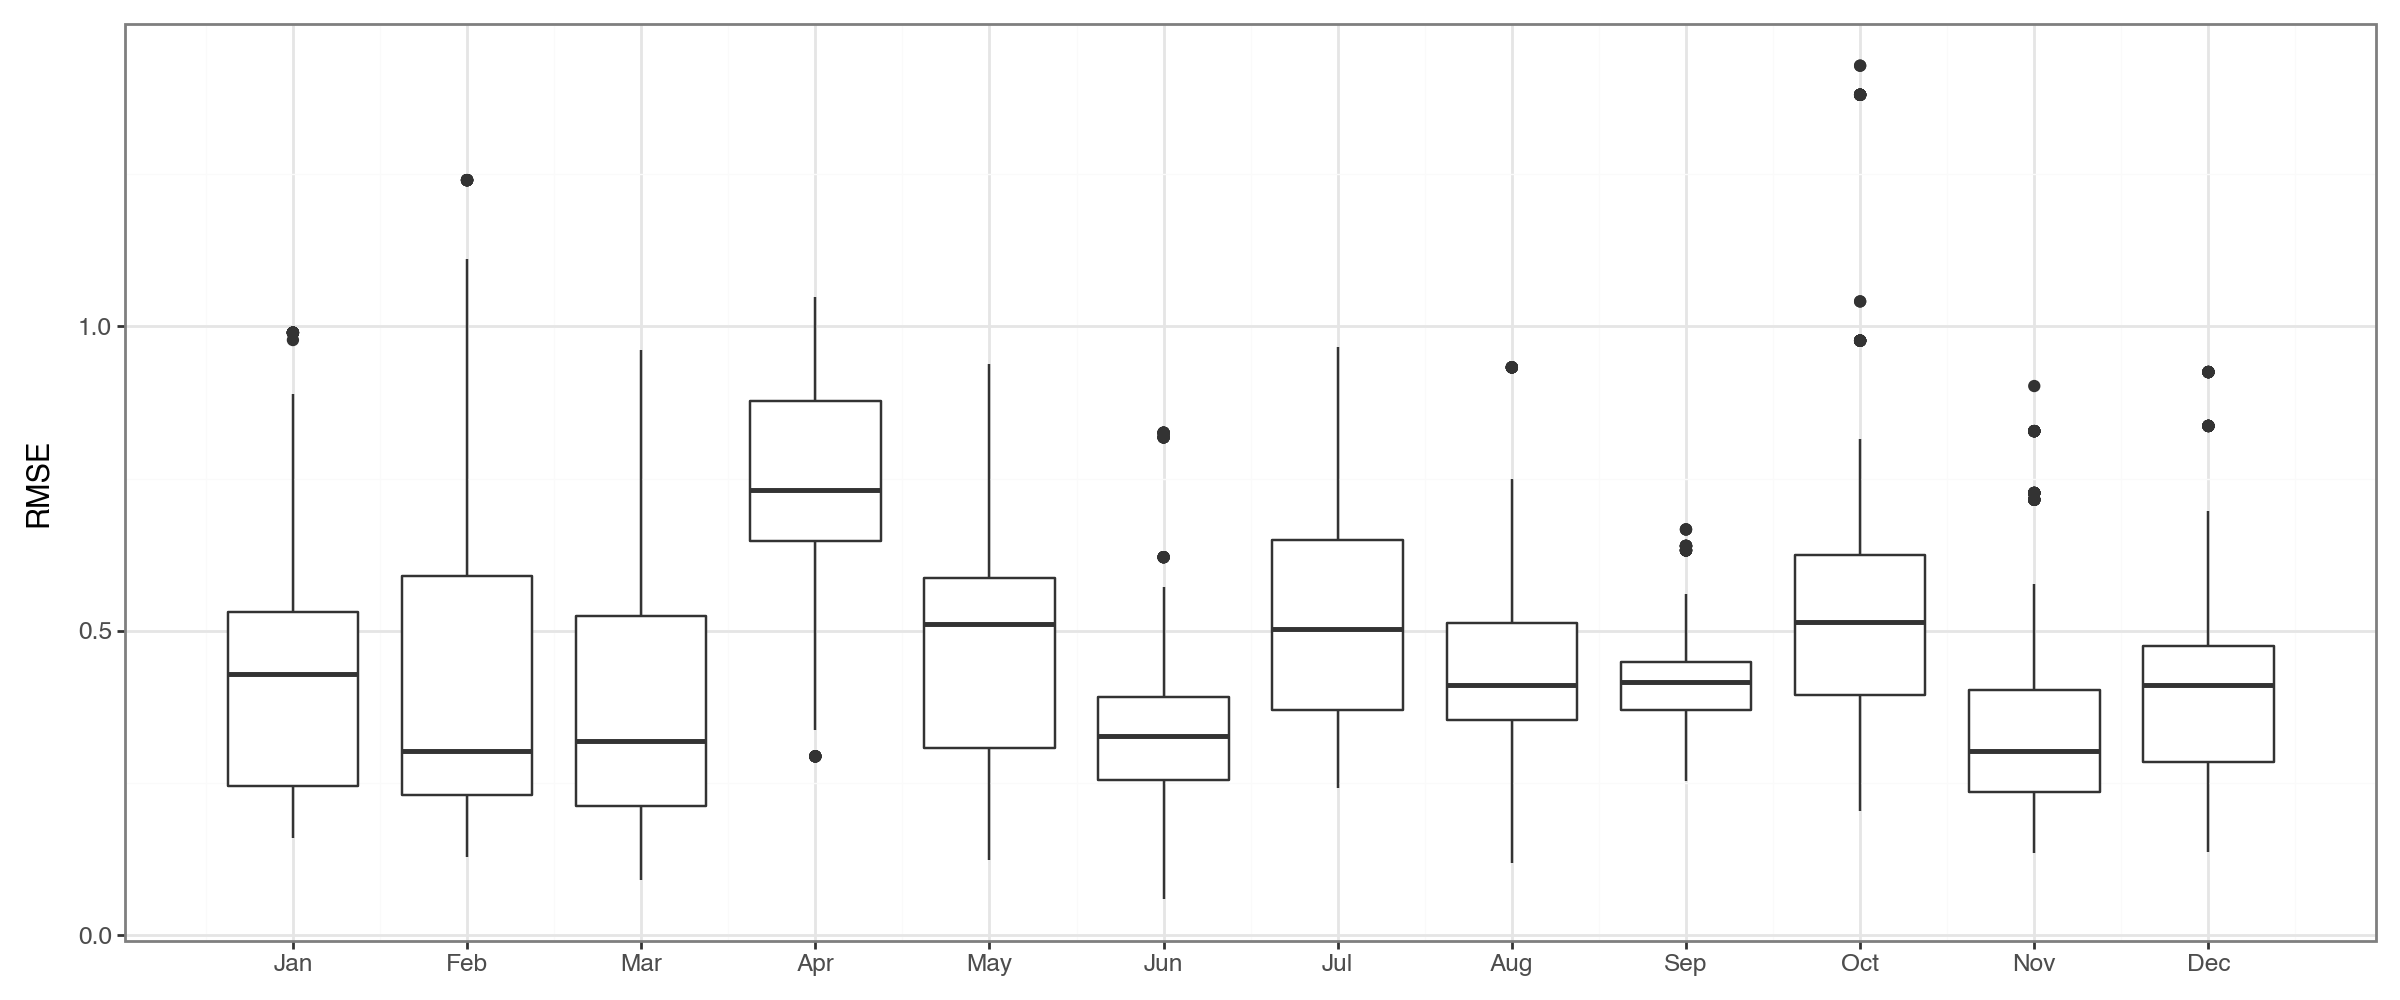

In [ ]:
rmse_df = (
    test_preds.groupby([test_preds.Date.dt.month, "model", "lake", "steps_ahead"])
    .apply(summarize)
    .reset_index()
)

(
    ggplot(data=rmse_df, mapping=aes(x="Date", y="rmse", group="Date"))
    + geom_boxplot()
    + scale_x_continuous(breaks=np.arange(1, 13), labels=calendar.month_abbr[1:])
    + theme_bw()
    + ylab("RMSE")
    + theme(axis_title_x=element_blank(), figure_size=(12, 5))
)

In [ ]:
melted_data = test_preds.set_index(["Date", "lake", "model", "steps_ahead"]).melt(
    ignore_index=False
)
transformed_data = [
    y_scaler.inverse_transform(
        df.reset_index().pivot(
            index=["Date", "model", "steps_ahead"], columns="lake", values="value"
        )[["sup", "mic_hur", "eri", "ont"]]
    )
    .melt(ignore_index=False, value_name=grp[-1])
    .set_index("lake", append=True)
    for grp, df in melted_data.groupby(["variable"])
]

transformed_vals = pd.concat(transformed_data, axis=1).reset_index()

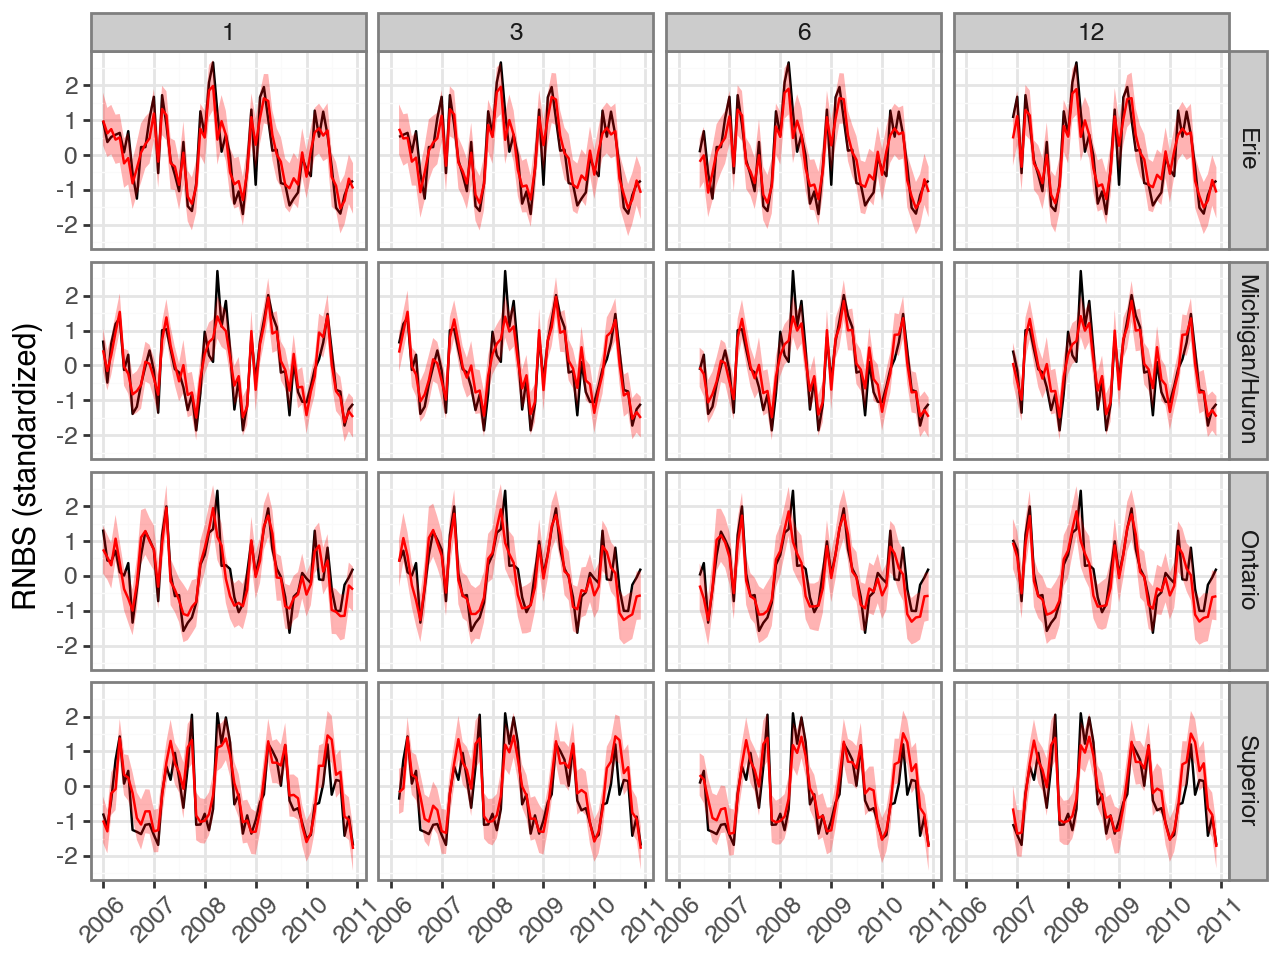

In [ ]:
plot_data = test_preds[
    (test_preds["model"] == "NARX") & test_preds["steps_ahead"].isin([1, 3, 6, 12])
]

(
    ggplot(data=plot_data, mapping=aes(x="Date", y="true"))
    + facet_grid("lake~steps_ahead", labeller=rename_lakes)
    + geom_line()
    + geom_line(mapping=aes(y="mean"), color="red")
    + theme_bw()
    + geom_ribbon(aes(ymin="lower", ymax="upper", y="mean"), fill="red", alpha=0.3)
    + scale_x_datetime(
        limits=[plot_data.Date.min(), plot_data.Date.max()],
        labels=date_format(fmt="%Y"),
        breaks=date_breaks("1 year"),
    )
    + theme(axis_text_x=element_text(angle=45), axis_title_x=element_blank())
    + ylab("RNBS (standardized)")
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


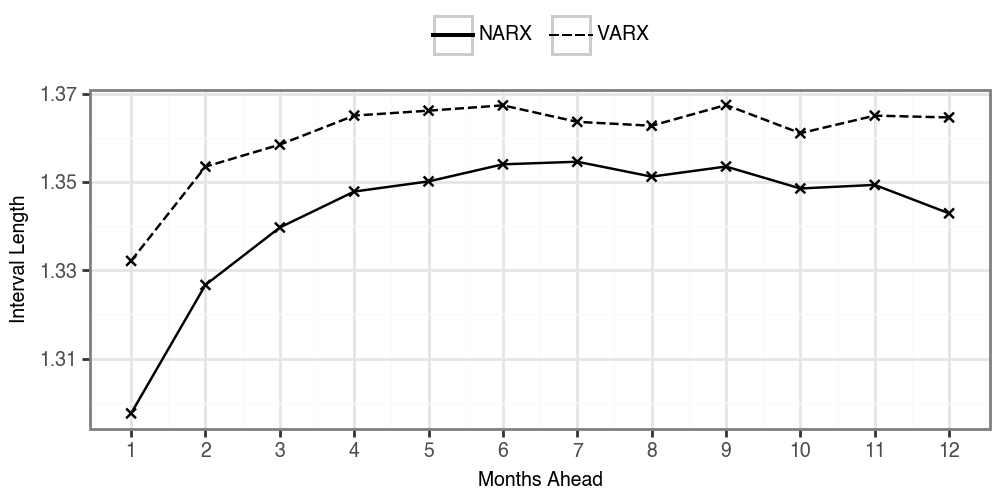

In [ ]:
plot_data = test_preds.groupby(["model", "steps_ahead"]).apply(summarize).reset_index()
plot_data = plot_data[plot_data["model"].isin(["VARX", "NARX"])]

(
    ggplot(
        data=plot_data, mapping=aes(x="steps_ahead", y="interval_len", linetype="model")
    )
    + geom_line()
    + theme_bw()
    + geom_point(shape="x")
    + theme(
        legend_position="top",
        legend_title=element_blank(),
        figure_size=(5, 2.5),
        text=element_text(size=7),
    )
    + scale_color_brewer(palette="Dark2", type="qual", name="Model")
    + scale_x_continuous(breaks=np.arange(1, 13))
    + ylab("Interval Length")
    + xlab("Months Ahead")
)

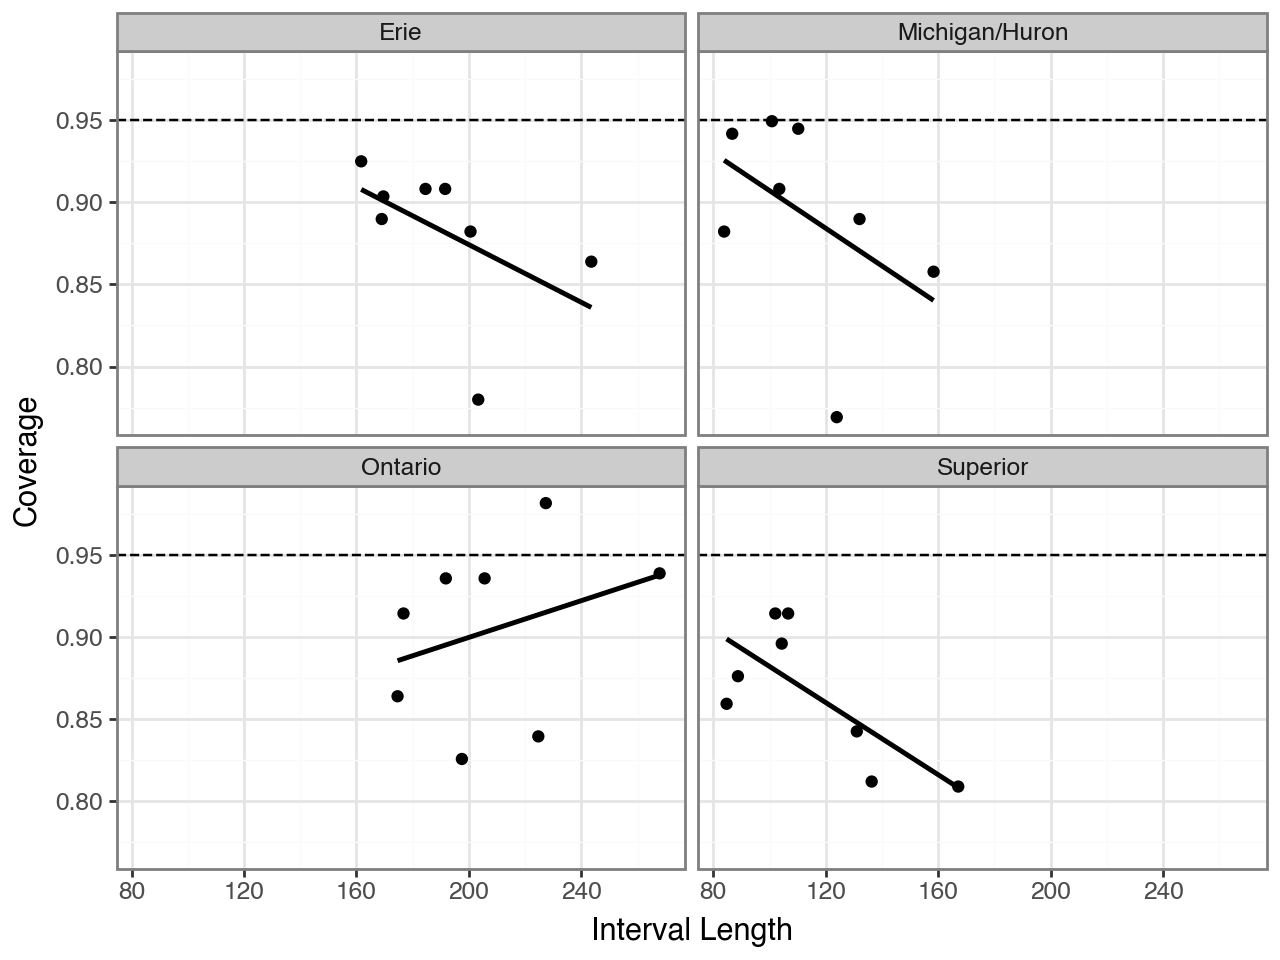

In [ ]:
scatter_data = (
    transformed_vals.groupby(["model", "lake"]).apply(summarize).reset_index()
)
scatter_data["method_type"] = np.where(
    scatter_data["model"].isin(["VARX", "NARX"]), "AR", "Non-AR"
)
(
    ggplot(data=scatter_data, mapping=aes(x="interval_len", y="coverage"))
    + geom_hline(yintercept=0.95, linetype="--")
    + geom_point()
    + geom_smooth(method="lm", se=False)
    + facet_wrap("~lake", nrow=2, labeller=rename_lakes)
    + theme_bw()
    + theme(legend_position="right", legend_title=element_blank())
    + scale_color_brewer(palette="Dark2", type="qual", name="Method Type")
    + ylab("Coverage")
    + xlab("Interval Length")
)

In [ ]:
agg_values = ["coverage", "interval_len"]
lake_table = test_preds.groupby(["model", "lake"]).apply(summarize)[agg_values]

model_display_names = {
    "BoostedTrees": "Boosted Trees",
    "SimpleLM": "Linear Model",
    "Default": "Default Ensemble",
    "GP_Matern": "Gaussian Process",
    "MultitaskGP": "Multitask GP",
    "NARX": "NARX",
    "VARX": "VARX",
    "RF": "Random Forest",
}
lake_table.index = pd.MultiIndex.from_tuples(
    [
        (model_display_names[model], rename_lakes(lake))
        for model, lake in lake_table.index
    ],
    names=["model", "lake"],
)

lake_table = (
    lake_table.melt(ignore_index=False)
    .reset_index()
    .pivot_table(index=["model", "variable"], columns=["lake"], values="value")
)

full_table = test_preds.groupby("model").apply(summarize)[agg_values]
full_table.index = pd.Index(
    [model_display_names[model] for model in full_table.index], name="model"
)

full_table = (
    full_table.melt(ignore_index=False)
    .reset_index()
    .assign(lake="All")
    .pivot_table(index=["model", "variable"], columns=["lake"], values="value")
)
merged_table = lake_table.merge(full_table, left_index=True, right_index=True)

print(
    merged_table.melt(ignore_index=False)
    .reset_index()
    .pivot(index=["model"], columns=["lake", "variable"], values="value")
    .to_latex(float_format="%0.3f")
)

\begin{tabular}{lrrrrrrrrrr}
\toprule
lake & \multicolumn{2}{r}{Erie} & \multicolumn{2}{r}{Michigan/Huron} & \multicolumn{2}{r}{Ontario} & \multicolumn{2}{r}{Superior} & \multicolumn{2}{r}{All} \\
variable & coverage & interval_len & coverage & interval_len & coverage & interval_len & coverage & interval_len & coverage & interval_len \\
model &  &  &  &  &  &  &  &  &  &  \\
\midrule
Boosted Trees & 0.780 & 1.867 & 0.769 & 1.745 & 0.826 & 1.598 & 0.809 & 2.432 & 0.796 & 1.910 \\
Default Ensemble & 0.864 & 2.236 & 0.858 & 2.229 & 0.939 & 2.167 & 0.812 & 1.984 & 0.868 & 2.154 \\
Gaussian Process & 0.890 & 1.552 & 0.945 & 1.552 & 0.936 & 1.552 & 0.914 & 1.552 & 0.921 & 1.552 \\
Linear Model & 0.908 & 1.759 & 0.950 & 1.420 & 0.982 & 1.839 & 0.896 & 1.519 & 0.934 & 1.634 \\
Multitask GP & 0.908 & 1.695 & 0.908 & 1.457 & 0.936 & 1.663 & 0.914 & 1.485 & 0.917 & 1.575 \\
NARX & 0.925 & 1.485 & 0.882 & 1.181 & 0.864 & 1.413 & 0.876 & 1.292 & 0.887 & 1.342 \\
Random Forest & 0.882 & 1.842 & 0.89

In [ ]:
test_preds.groupby("model").apply(summarize).sort_values("rmse", ascending=True)

,rmse,mae,mape,variance,bias,coverage,interval_len,crps,N,r2
model,,,,,,,,,,
VARX,0.417,0.314,2.334,0.173,0.032,0.905,1.360,0.229,"2,616.000",0.793
NARX,0.438,0.339,4.445,0.190,0.038,0.887,1.342,0.244,"2,616.000",0.763
GP_Matern,0.439,0.333,1.034,0.192,0.024,0.921,1.552,0.240,"2,616.000",0.758
SimpleLM,0.455,0.349,0.900,0.206,0.030,0.934,1.634,0.251,"2,616.000",0.724
MultitaskGP,0.457,0.344,1.769,0.209,0.012,0.917,1.575,0.250,"2,616.000",0.738
BoostedTrees,0.474,0.370,5.583,0.225,-0.007,0.796,1.910,0.270,"2,616.000",0.690
RF,0.549,0.435,1.461,0.300,0.032,0.864,1.856,0.307,"2,616.000",0.583
Default,0.691,0.551,3.067,0.476,0.031,0.868,2.154,0.388,"2,616.000",0.207


INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


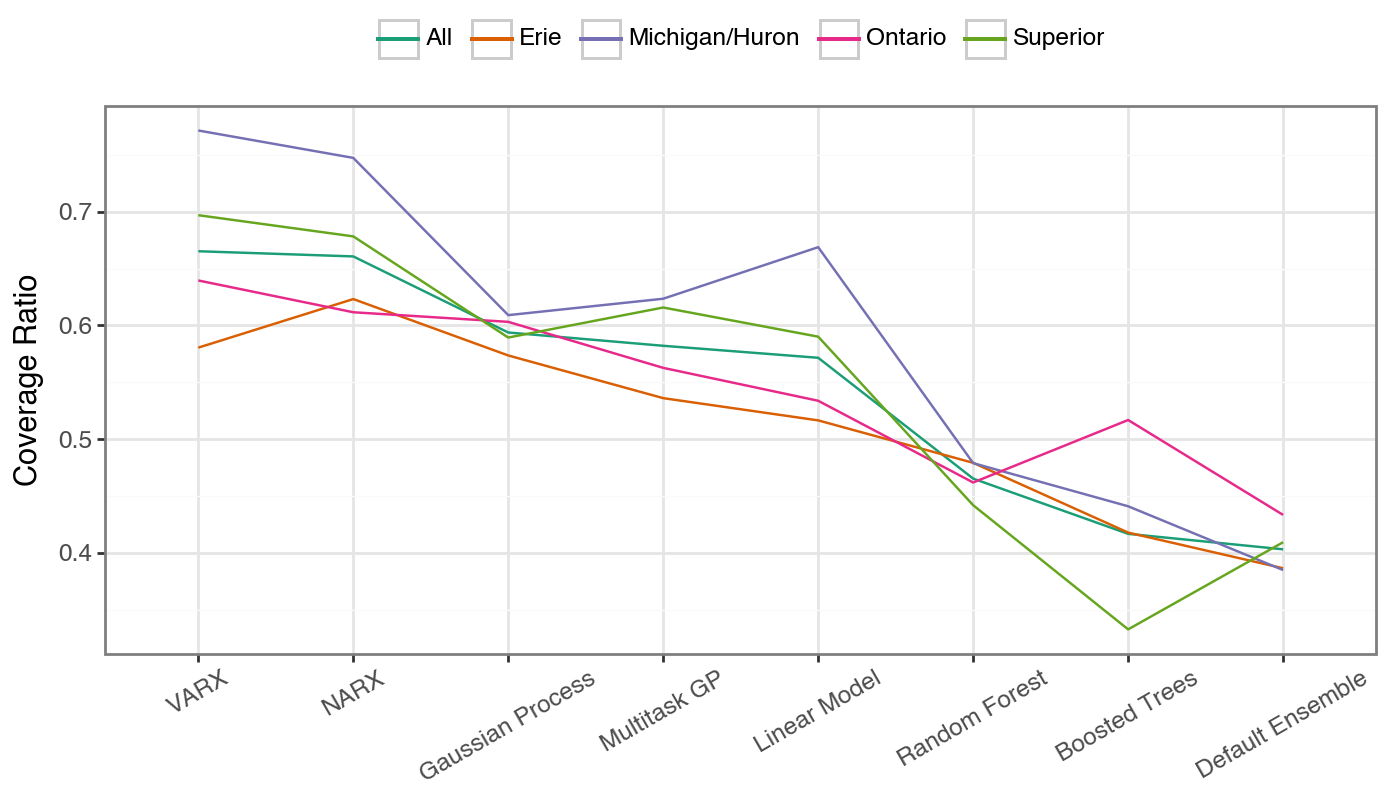

In [ ]:
ratios = (
    merged_table.melt(ignore_index=False)
    .reset_index()
    .pivot(columns=["variable"], index=["model", "lake"], values="value")
)
ratios["coverage_ratio"] = ratios["coverage"] / ratios["interval_len"]
plot_data = ratios.sort_values(["lake", "model"], ascending=False).reset_index()

(
    ggplot(
        data=plot_data,
        mapping=aes(
            x="reorder(model, -coverage_ratio)",
            y="coverage_ratio",
            group="lake",
            color="lake",
        ),
    )
    + geom_line()
    + scale_color_brewer(palette="Dark2", type="qual")
    + theme_bw()
    + theme(
        axis_text_x=element_text(angle=30),
        axis_title_x=element_blank(),
        figure_size=(7, 4.0),
        legend_position="top",
        legend_title=element_blank(),
    )
    + ylab("Coverage Ratio")
    # + guides(color=guide_legend(title=element_blank()))
)

INFO:matplotlib.font_manager:Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


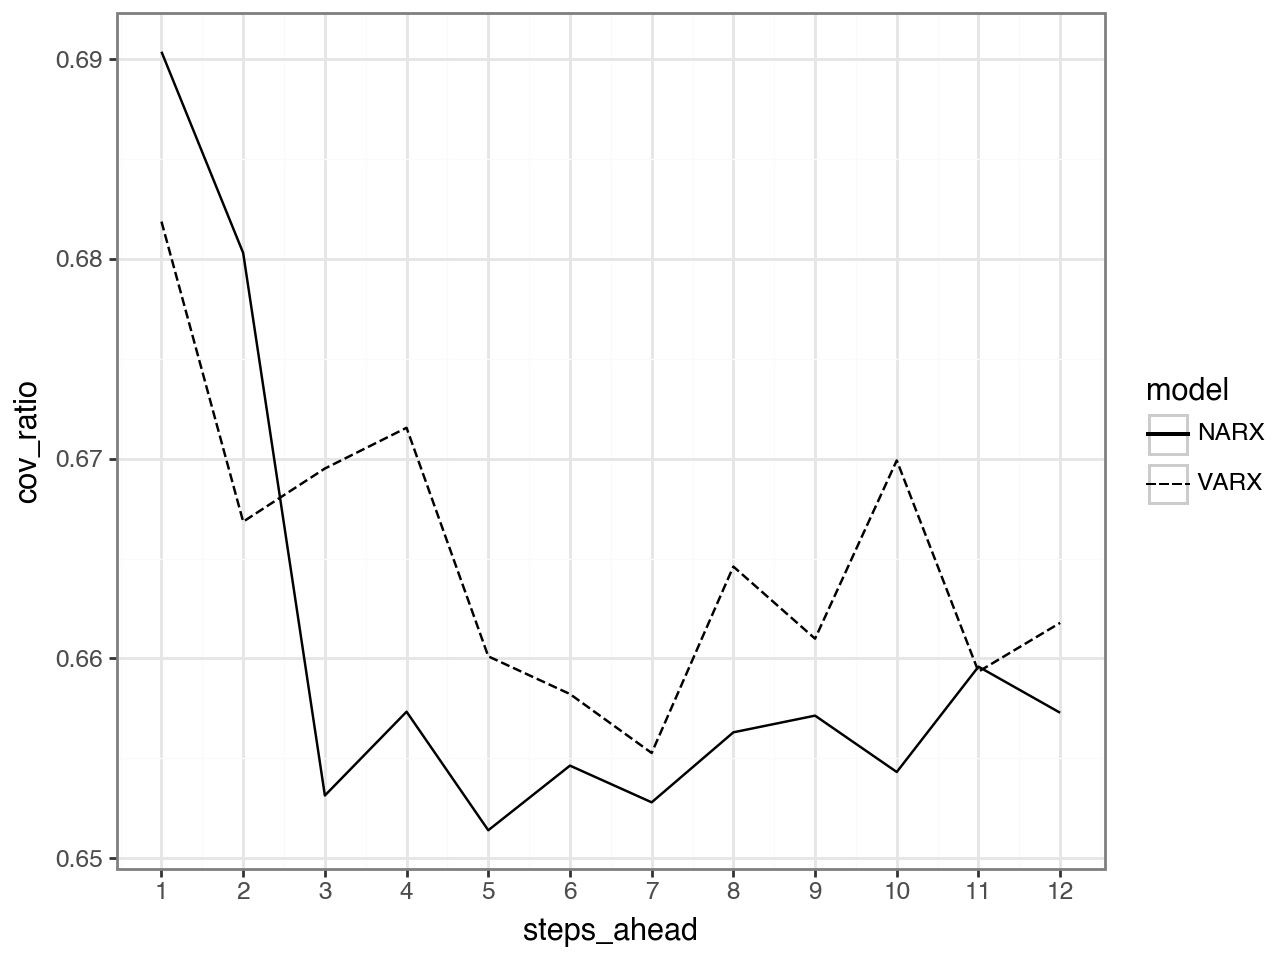

In [ ]:
plot_data = (
    test_preds[test_preds["model"].isin(["VARX", "NARX"])]
    .groupby(["model", "steps_ahead"])
    .apply(summarize)
    .reset_index()
)
plot_data["cov_ratio"] = plot_data["coverage"] / plot_data["interval_len"]

(
    ggplot(
        data=plot_data, mapping=aes(x="steps_ahead", y="cov_ratio", linetype="model")
    )
    + geom_line()
    + theme_bw()
    + scale_x_continuous(breaks=np.arange(1, 13))
)